## Measuring Colorfulness in Natural Images
Paper: https://infoscience.epfl.ch/entities/publication/e64ec735-2e1b-45ea-bc83-71f6d735068e \
Implementation: https://pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/


In [33]:
import sys
import os
import csv
import numpy as np
import requests
import cv2
from PIL import Image as PIL_Image
from io import BytesIO
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from visual_genome.local import VisualGenome

In [ ]:
vg = VisualGenome()

In [16]:
def get_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float")) # CV2 stores images in BGR format
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [ ]:
image_colorfulness = {} # a dictionary from image_id to colorfulness

# read image ids from image_colorfulness.csv
images = []
with open('image_colorfulness.csv', 'r') as f:
    reader = csv.reader(f)
    # skip the header
    next(reader)
    for row in reader:
        images.append(int(row[0]))

print(images)
for im in tqdm(images, desc="Processing Images"):
    image = vg.get_image(id=im)

    response = requests.get(image.url)
    img_pil = PIL_Image.open(BytesIO(response.content))
    
    img_cv = np.array(img_pil)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
    
    # img_cv is a 3d numpy array 
    colorfulness = get_colorfulness(img_cv)
    image_colorfulness[im] = colorfulness

In [30]:
# write to csv

with open('image_colorfulness.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['image_id', 'colorfulness'])
    for im, colorfulness in image_colorfulness.items():
        writer.writerow([im, colorfulness])
        

In [ ]:
# histogram of colorfulness
import matplotlib.pyplot as plt
plt.hist(image_colorfulness.values(), bins=100)
plt.xlabel('Colorfulness')
plt.ylabel('Frequency')
plt.title('Colorfulness Histogram')


In [ ]:
# sample image with colorfulness > 80
high_colorfulness = {k: v for k, v in image_colorfulness.items() if v > 80}

# sample image with colorfulness < 20
low_colorfulness = {k: v for k, v in image_colorfulness.items() if v < 20}

a = list(high_colorfulness.keys())
b = list(low_colorfulness.keys())
# randomly sample
import random
random.shuffle(a)
random.shuffle(b)

In [ ]:
# visualize 9 images from both sides
vg.visualize_images_side_by_side(a[:9])

vg.visualize_images_side_by_side(b[:9])

In [43]:
def combine_bounding_boxes(objs, im):
    # get im size
    width, height = im.width, im.height
    area = width * height
    
    # iterate through the bounding boxes and get the union of pixels 
    pixels = set()
    for obj in objs:
        x = obj.x
        y = obj.y
        w = obj.width
        h = obj.height
        
        for i in range(x, x+w):
            for j in range(y, y+h):
                if i < width and i >= 0 and j >= 0 and  j < height:
                    pixels.add((i, j))

    return pixels, len(pixels) / area  # return pixels and ratio of pixels to whole area
    

In [ ]:
import csv
import requests
from PIL import Image as PIL_Image
from io import BytesIO
import numpy as np
import cv2
from tqdm import tqdm

# Assuming get_colorfulness, vg.get_image, and combine_bounding_boxes are defined elsewhere.

# Initialize a dictionary to store colorfulness by image_id
image_colorfulness_bbox = {}

# Read image ids from image_colorfulness.csv
images = []
image_colorfulness = {}
with open('image_colorfulness.csv', 'r') as f:
    reader = csv.reader(f)
    # Skip the header
    next(reader)
    for row in reader:
        images.append(int(row[0]))
        image_colorfulness[int(row[0])] = float(row[1])

im_to_ratio = {}

# Process each image
for im in tqdm(images, desc="Processing Images"):
    # Fetch the image
    image = vg.get_image(id=im)
    response = requests.get(image.url)
    
    # Open the image as a PIL image
    img_pil = PIL_Image.open(BytesIO(response.content))
    
    # Convert to OpenCV format (numpy array) and BGR for OpenCV operations
    img_cv = np.array(img_pil)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)

    # Call combine_bounding_boxes to get bounding box pixels and ratio
    pixels, ratio = combine_bounding_boxes(vg.get_image_objects(im), img_pil)  # Assuming image.objects gives bounding box data
    
    # Use the bounding box pixels to create a mask and apply it to img_cv
    mask = np.zeros((img_cv.shape[0], img_cv.shape[1]), dtype=np.uint8)
    
    # Set the bounding box pixels in the mask
    for (i, j) in pixels:
        mask[j, i] = 1  # Mask is in height (y), width (x) order

    # Apply the mask to the image (only keep pixels inside the bounding boxes)
    masked_img = cv2.bitwise_and(img_cv, img_cv, mask=mask)

    # Compute colorfulness on the masked image
    colorfulness = get_colorfulness(masked_img)
    
    # Store the result in the dictionary
    image_colorfulness_bbox[im] = {
        "colorfulness_full_image": image_colorfulness[im],
        "colorfulness_union_bbox": colorfulness,
        "bounding_box_ratio": ratio
    }
    


0.7824687246299493


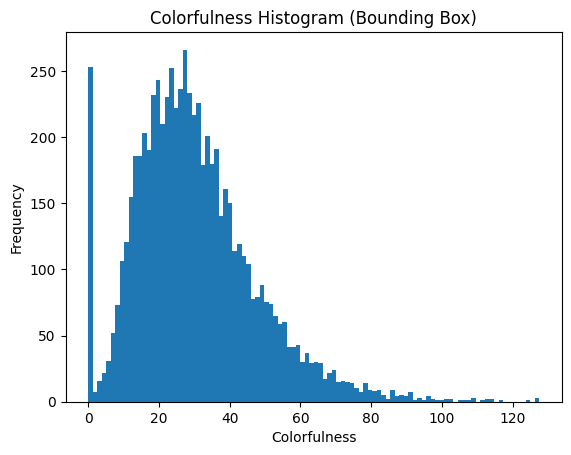

In [49]:
# calculate mean bounding box ratio
mean_ratio = np.mean([v['bounding_box_ratio'] for v in image_colorfulness_bbox.values()])
print(mean_ratio)

# calculate correlation between colorfulness and bounding box ratio
colorfulness_values = [v['colorfulness_full_image'] for v in image_colorfulness_bbox.values()]
colorfulness_bbox_values = [v['colorfulness_union_bbox'] for v in image_colorfulness_bbox.values()]

import scipy.stats
print(scipy.stats.pearsonr(colorfulness_values, colorfulness_bbox_values))

# histogram for colorfulness_bbox_values
plt.hist(colorfulness_bbox_values, bins=100)
plt.xlabel('Colorfulness')
plt.ylabel('Frequency')
plt.title('Colorfulness Histogram (Bounding Box)')
plt.show()



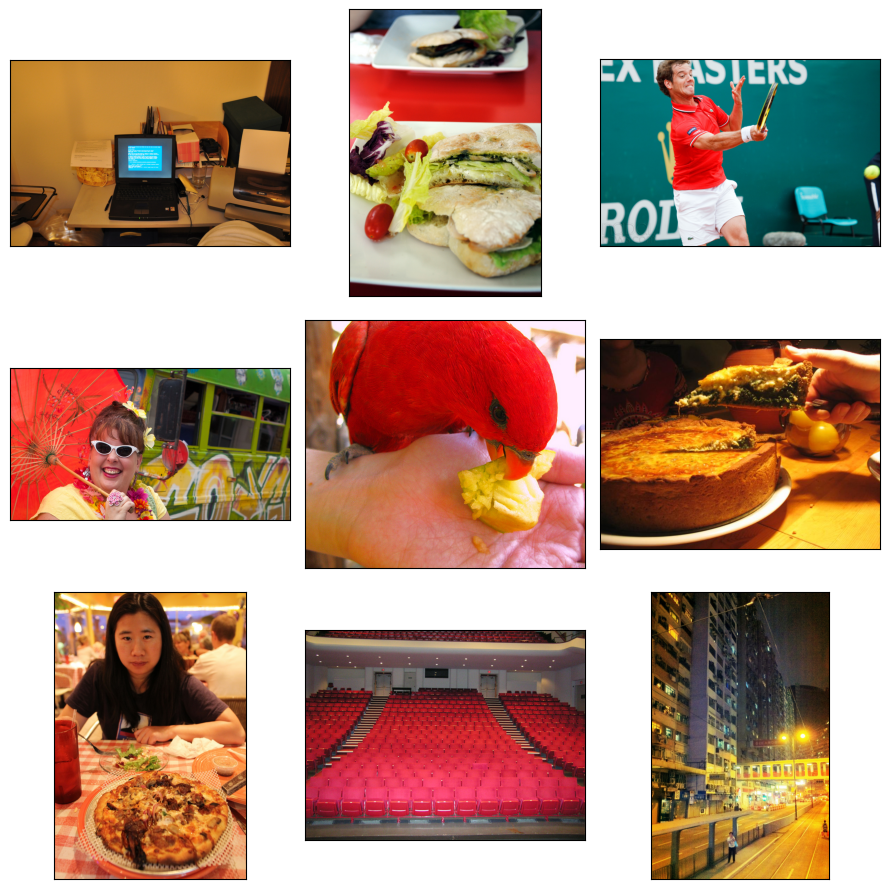

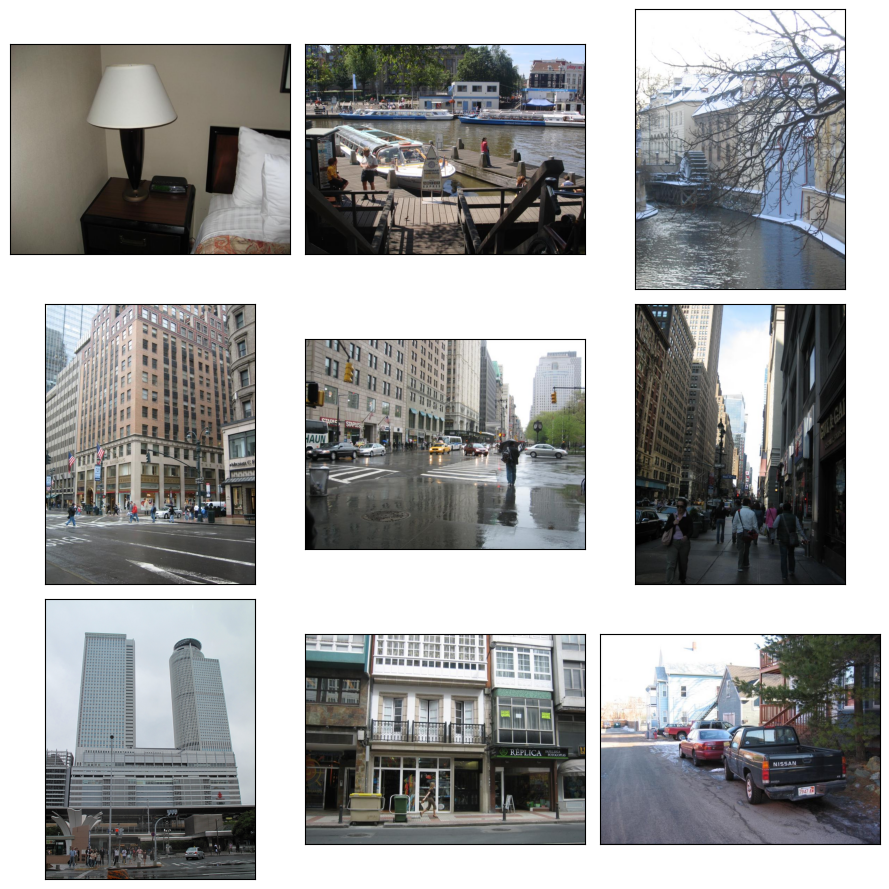

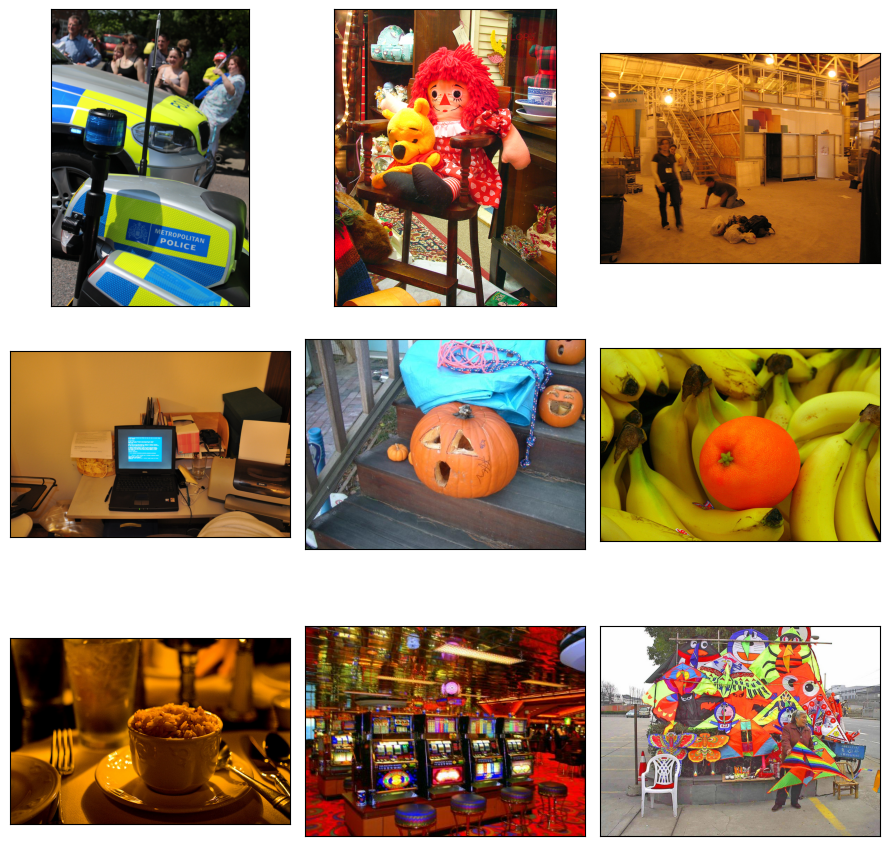

In [51]:
# sample colorfulness > 80
high_colorfulness = {k: v for k, v in image_colorfulness_bbox.items() if v['colorfulness_full_image'] > 80}
low_colorfulness = {k: v for k, v in image_colorfulness_bbox.items() if v['colorfulness_full_image'] < 20}

a = list(high_colorfulness.keys())
b = list(low_colorfulness.keys())

# randomly sample
import random
random.shuffle(a)
random.shuffle(b)

# visualize 9 images from both sides
vg.visualize_images_side_by_side(a[:9])
vg.visualize_images_side_by_side(b[:9])

# find a high coolorful image with low bounding box ratio
high_colorful_low_ratio = {k: v for k, v in image_colorfulness_bbox.items() if v['colorfulness_full_image'] > 80 and v['bounding_box_ratio'] < mean_ratio}

a = list(high_colorful_low_ratio.keys())
random.shuffle(a)
print("High Colorful, Low Bounding Box Ratio to Overall Image")
vg.visualize_images_side_by_side(a[:9])
